# Random Forest Model using Bag of Words

# Imports and Constants

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import ast
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import LabelBinarizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import model_helper_functions

In [2]:
DATA_PATH = '../data/'
PRE_PROCESSED_DATA_FILE_NAME = 'news_dataset_pre_processed.csv'
RANDOM_STATE = 42
pd.options.display.max_seq_items = 20
pd.options.display.max_rows = 50

# Load Data

In [3]:
df = pd.read_csv(DATA_PATH + PRE_PROCESSED_DATA_FILE_NAME, 
                 low_memory = False, 
                 usecols = ['title', 'text', 'label', 'clean_text_tokens', 'clean_title_tokens'])

In [4]:
df.clean_text_tokens = df.clean_text_tokens.map(ast.literal_eval)
df.clean_title_tokens = df.clean_title_tokens.map(ast.literal_eval)

In [5]:
df.head()

,title,text,label,clean_text_tokens,clean_title_tokens
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,fake,"[donald, trump, just, couldn, wish, all, ameri...","[donald, trump, sends, out, embarrassing, new,..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,fake,"[house, intelligence, committee, chairman, dev...","[drunk, bragging, trump, staffer, started, rus..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",fake,"[on, friday, it, was, revealed, that, former, ...","[sheriff, david, clarke, becomes, an, internet..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",fake,"[on, christmas, day, donald, trump, announced,...","[trump, is, so, obsessed, he, even, has, obama..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,fake,"[pope, francis, used, his, annual, christmas, ...","[pope, francis, just, called, out, donald, tru..."


# Split Data

In [6]:
y = df.label
X = df.drop('label', axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = y)

In [8]:
X_train.shape

(30910, 4)

In [9]:
X_test.shape

(7728, 4)

# Encode Labels

In [10]:
le = LabelEncoder()

In [11]:
y_train_enc = le.fit_transform(y_train)

In [12]:
y_test_enc = le.transform(y_test)

# Train Models

In [13]:
def train_and_eval_model(X_train, X_test, y_train_enc, y_test_enc, classes_,
                        preprocessor, tokenizer, max_df=1.0, ngram_range = (1, 1)):
    """
    Train and Evaluate and Bag of Words Representation with a Naive Bayes
    classifier.
    """
    
    pipeline = Pipeline([
    ('bow',CountVectorizer(min_df = 5, 
                           preprocessor = preprocessor, 
                           tokenizer = tokenizer, 
                           max_df = max_df, 
                           ngram_range = ngram_range)),  
    ('classifier', RandomForestClassifier(n_jobs = -1, 
                                          random_state = RANDOM_STATE)),
    ])
    
    pipeline.fit(X_train,y_train_enc)
    
    model_helper_functions.confustion_matrix_and_classification_report(pipeline, 
                                                X_train, 
                                                y_train_enc, 
                                                classes_, 
                                               'Training')

    model_helper_functions.confustion_matrix_and_classification_report(pipeline, 
                                                X_test, 
                                                y_test_enc, 
                                                classes_,
                                                'Test')
    
    return pipeline

## title only

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



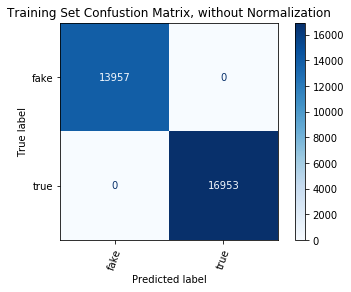

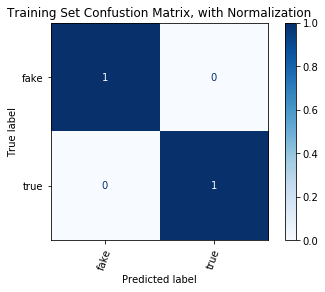

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.94      0.93      0.93      3490
        true       0.94      0.95      0.95      4238

    accuracy                           0.94      7728
   macro avg       0.94      0.94      0.94      7728
weighted avg       0.94      0.94      0.94      7728



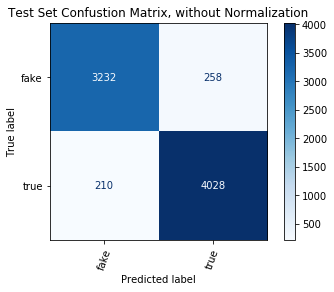

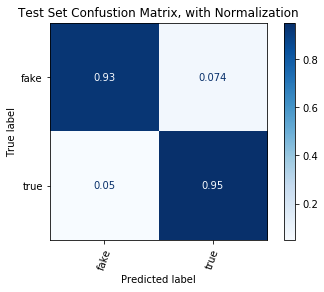

In [14]:
pipeline = train_and_eval_model(X_train = X_train['clean_title_tokens'], 
                                 X_test = X_test['clean_title_tokens'], 
                                 y_train_enc = y_train_enc, 
                                 y_test_enc = y_test_enc, 
                                 classes_ = le.classes_, 
                                 preprocessor = model_helper_functions.passthrough, 
                                 tokenizer = model_helper_functions.passthrough)

In [15]:
feature_importances = pd.DataFrame(pipeline['classifier'].feature_importances_, 
                                       index = pipeline['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
    
feature_importances.head(20)

,importance
VIDEO,0.072462
the,0.036173
video,0.030355
!,0.026933
U.S.,0.022161
WATCH,0.022150
is,0.016520
says,0.015102
just,0.013675
and,0.013198


## Title - Stopwords Removed

There are a lot of stopwords in the above model.  Let's see what the important features are with the stopwords removed.

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



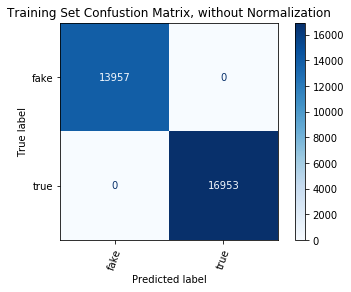

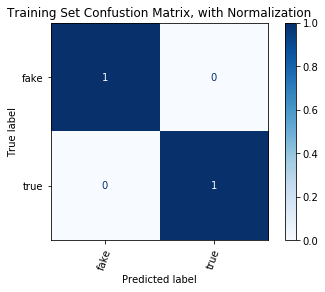

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.94      0.91      0.92      3490
        true       0.92      0.95      0.94      4238

    accuracy                           0.93      7728
   macro avg       0.93      0.93      0.93      7728
weighted avg       0.93      0.93      0.93      7728



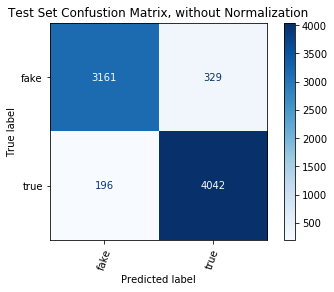

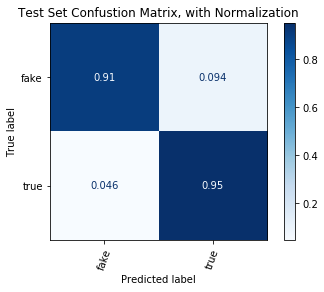

In [16]:
pipe_sw_removed = train_and_eval_model(X_train = X_train['clean_title_tokens'], 
                                 X_test = X_test['clean_title_tokens'], 
                                 y_train_enc = y_train_enc, 
                                 y_test_enc = y_test_enc, 
                                 classes_ = le.classes_, 
                                 preprocessor = model_helper_functions.passthrough, 
                                 tokenizer = model_helper_functions.remove_stopwords)

In [17]:
feat_imp_sw_removed = pd.DataFrame(pipe_sw_removed['classifier'].feature_importances_, 
                                       index = pipe_sw_removed['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_sw_removed.head(20)

,importance
VIDEO,0.078218
video,0.036633
U.S.,0.032821
!,0.028057
WATCH,0.023914
says,0.018839
hillary,0.015054
GOP,0.013735
BREAKING,0.010225
OBAMA,0.009315


## Title - Stopwords Removed and all Lowercase

About half of the important features for the above model are all caps.  Let's see which are important with everything is lowercase.

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



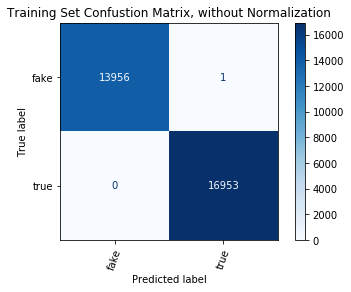

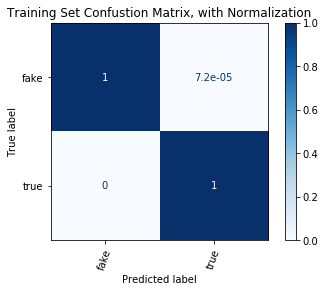

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.93      0.90      0.91      3490
        true       0.92      0.95      0.93      4238

    accuracy                           0.92      7728
   macro avg       0.92      0.92      0.92      7728
weighted avg       0.92      0.92      0.92      7728



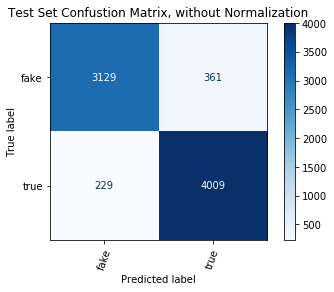

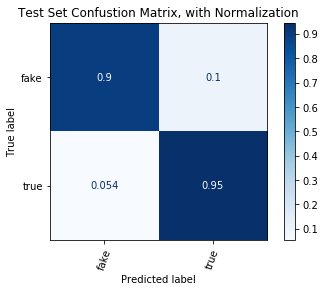

In [18]:
pipe_lc_sw_rm = train_and_eval_model(X_train = X_train['clean_title_tokens'], 
                     X_test = X_test['clean_title_tokens'], 
                     y_train_enc = y_train_enc, 
                     y_test_enc = y_test_enc, 
                     classes_ = le.classes_, 
                     preprocessor = model_helper_functions.lowercase_tokens, 
                     tokenizer = model_helper_functions.remove_stopwords)

In [19]:
feat_imp_lc_sw_rm = pd.DataFrame(pipe_lc_sw_rm['classifier'].feature_importances_, 
                                       index = pipe_lc_sw_rm['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_lc_sw_rm.head(20)

,importance
video,0.111465
!,0.029724
u.s.,0.027826
watch,0.026187
hillary,0.021091
says,0.019193
gop,0.014936
trump,0.012915
breaking,0.011527
donald,0.009782


## Title - Stopwords Removed, all Lowercase, N-Gram (1,2)

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



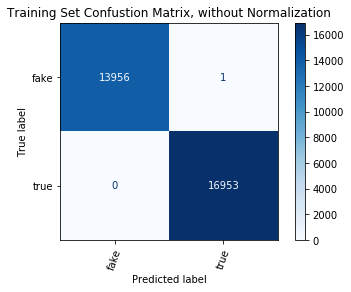

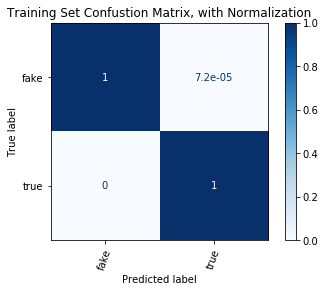

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.93      0.90      0.91      3490
        true       0.92      0.94      0.93      4238

    accuracy                           0.92      7728
   macro avg       0.92      0.92      0.92      7728
weighted avg       0.92      0.92      0.92      7728



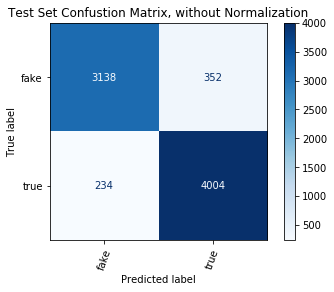

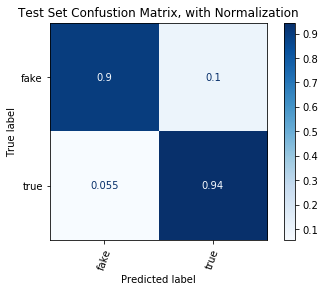

In [21]:
pipe_sw_rm_lc_ng = train_and_eval_model(X_train = X_train['clean_title_tokens'], 
                                         X_test = X_test['clean_title_tokens'], 
                                         y_train_enc = y_train_enc, 
                                         y_test_enc = y_test_enc, 
                                         classes_ = le.classes_, 
                                         preprocessor = model_helper_functions.lowercase_and_remove_stopwords, 
                                         tokenizer = model_helper_functions.passthrough, 
                                         ngram_range = (1, 2))

In [24]:
feat_imp_sw_rm_lc_ng = pd.DataFrame(pipe_sw_rm_lc_ng['classifier'].feature_importances_, 
                                       index = pipe_sw_rm_lc_ng['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_sw_rm_lc_ng.head(20)

,importance
video,0.103032
u.s.,0.027770
watch,0.026194
!,0.025806
hillary,0.021821
gop,0.015077
says,0.013895
breaking,0.010391
trump,0.009948
tweets,0.008577


## Title and Text

In [25]:
X_train['title_and_text'] = X_train['clean_title_tokens'] + X_train['clean_text_tokens']
X_test['title_and_text'] = X_test['clean_title_tokens'] + X_test['clean_text_tokens']

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



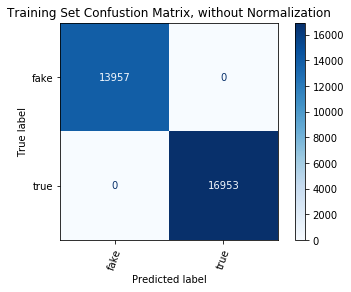

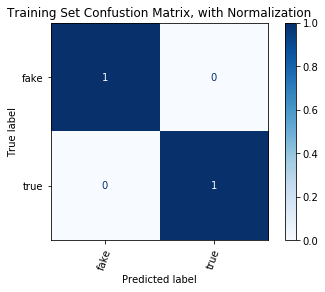

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.99      0.97      0.98      3490
        true       0.97      0.99      0.98      4238

    accuracy                           0.98      7728
   macro avg       0.98      0.98      0.98      7728
weighted avg       0.98      0.98      0.98      7728



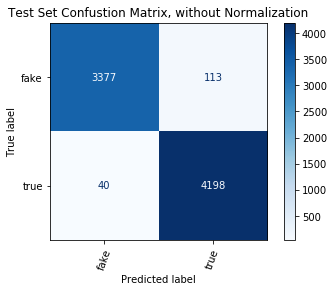

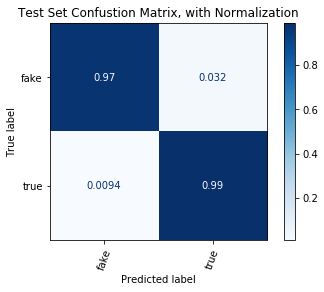

In [26]:
pipe_title_text = train_and_eval_model(X_train['title_and_text'], 
                                       X_test['title_and_text'],
                                       y_train_enc, 
                                       y_test_enc, 
                                       le.classes_, 
                                       model_helper_functions.passthrough, 
                                       model_helper_functions.passthrough)

In [27]:
feat_imp_title_text = pd.DataFrame(pipe_title_text['classifier'].feature_importances_, 
                                       index = pipe_title_text['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_title_text.head(20)

,importance
image,0.026256
said,0.025056
via,0.020077
U.S.,0.016132
!,0.013958
video,0.012726
VIDEO,0.011878
WASHINGTON,0.010387
you,0.009318
on,0.008568


## Title and Text - lowercase, lemmatize

The above feature list contains singular and plural versions of words as well as all caps and lowercase.  Let's see what the performance and feature importances are with all lowercase and lemmatization.

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



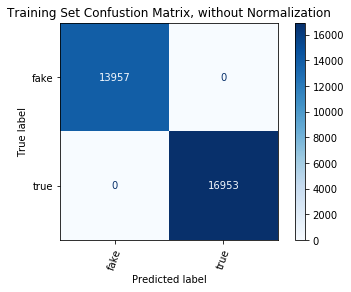

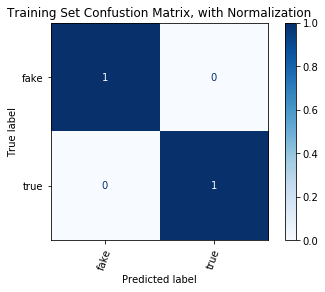

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.98      0.96      0.97      3490
        true       0.97      0.99      0.98      4238

    accuracy                           0.97      7728
   macro avg       0.98      0.97      0.97      7728
weighted avg       0.97      0.97      0.97      7728



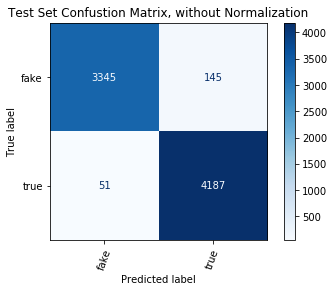

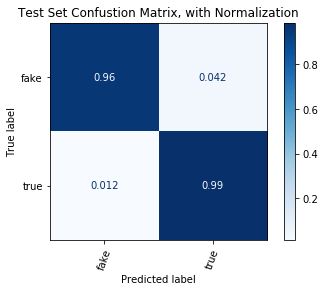

In [28]:
pipe_title_text_lc_lemma = train_and_eval_model(X_train['title_and_text'], 
                                       X_test['title_and_text'],
                                       y_train_enc, 
                                       y_test_enc, 
                                       le.classes_, 
                                       model_helper_functions.lowercase_tokens, 
                                       model_helper_functions.LemmaTokenizer())

In [29]:
feat_imp_title_text_lc_lemma = pd.DataFrame(pipe_title_text_lc_lemma['classifier'].feature_importances_, 
                                       index = pipe_title_text_lc_lemma['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_title_text_lc_lemma.head(20)

,importance
said,0.032933
video,0.024661
via,0.023202
image,0.019335
u.s.,0.018094
!,0.012842
just,0.010460
washington,0.008835
you,0.008792
twitter-handle,0.008273


## Title and Text - lowercase, lemmatize, no stopwords

The list of important features from the above model contains a lot of stopwords.  Let's see what it looks like with the stopwords removed.

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



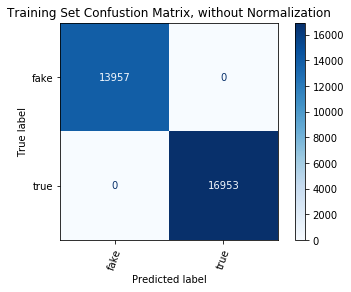

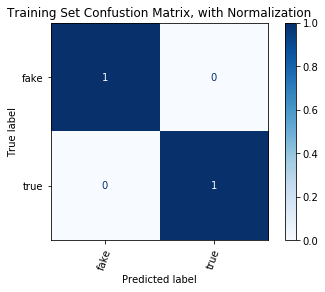

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.99      0.96      0.97      3490
        true       0.97      0.99      0.98      4238

    accuracy                           0.98      7728
   macro avg       0.98      0.98      0.98      7728
weighted avg       0.98      0.98      0.98      7728



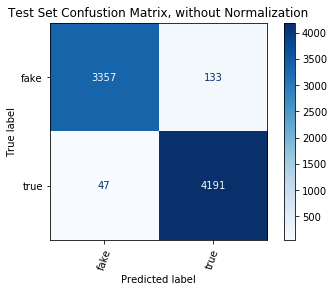

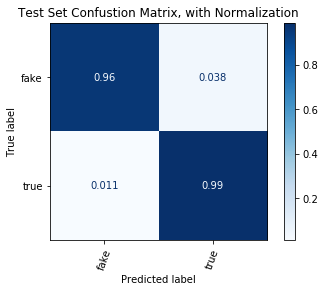

In [30]:
pipe_title_text_lc_lemma_no_sw = train_and_eval_model(X_train['title_and_text'], 
                                       X_test['title_and_text'],
                                       y_train_enc, 
                                       y_test_enc, 
                                       le.classes_, 
                                       model_helper_functions.lowercase_and_remove_stopwords, 
                                       model_helper_functions.LemmaTokenizer())

In [31]:
feat_imp_title_text_lc_lemma = pd.DataFrame(pipe_title_text_lc_lemma_no_sw['classifier'].feature_importances_, 
                                       index = pipe_title_text_lc_lemma_no_sw['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_title_text_lc_lemma.head(20)

,importance
via,0.027627
said,0.025007
image,0.024420
!,0.019470
video,0.019268
u.s.,0.019132
washington,0.010814
twitter-handle,0.008914
like,0.008842
watch,0.008342
